<a href="https://colab.research.google.com/github.com/hituji1012/CreateRealFace/AnimeToReal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 手順


1.   dlib使ってアニメから顔を切り取り
2.   e4eで潜在変数作成
3.   stylegan読み込み
4.   実写に変換

In [1]:
!git clone https://github.com/hituji1012/CreateRealFace.git
%cd CreateRealFace
!pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

Cloning into 'CreateRealFace'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 101 (delta 12), reused 99 (delta 10), pack-reused 0
Receiving objects: 100% (101/101), 32.90 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/CreateRealFace
     |████████████████████████████████| 7.0 MB 14.5 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 1.7 MB 80.7 MB/s 
     |████████████████████████████████| 144 kB 84.9 MB/s 
     |████████████████████████████████| 181 kB 76.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=9be4041349c30d77aa7b2dd4ede8619a8d8401b94a01fe10b240cc19a481c4b4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
 

In [2]:
import os
os.makedirs('models', exist_ok=True)
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline

--2022-03-06 06:32:54--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  21.0MB/s    in 2.9s    

2022-03-06 06:32:57 (21.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb
from model import *
from e4e_projection import projection as e4e_projection

from copy import deepcopy

## 1. dlib使ってアニメから顔を切り取り

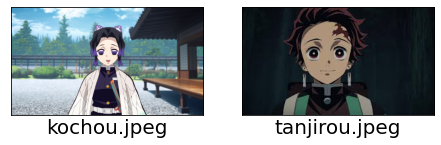

In [5]:
#@title サンプル画像の表示
%matplotlib inline
display_pic('pic')

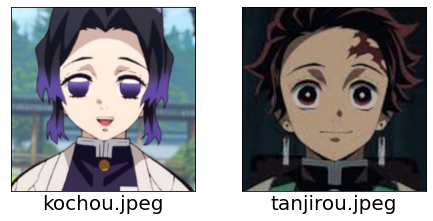

In [6]:
import os
import shutil

# alignフォルダーリセット
if os.path.isdir('align'):
    shutil.rmtree('align')
os.makedirs('align', exist_ok=True)

# picフォルダの画像をalignし、alignフォルダに保存
files = sorted(os.listdir('./pic'))
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    aligned_face = align_face('./pic/'+file)
    aligned_face.save('./align/'+file)
  
display_pic('align')

## 2. e4eで潜在変数作成

In [13]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}
device = 'cuda' #@param ['cuda', 'cpu']

In [8]:
drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
}

In [9]:
# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst

In [10]:
downloader = Downloader(download_with_pydrive)

downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

In [11]:
# vectorsフォルダーリセット
if os.path.isdir('vectors'):
    shutil.rmtree('vectors')
os.makedirs('vectors', exist_ok=True)

In [14]:
# alignフォルダの画像の潜在変数を求め、vectorsフォルダに保存
files = sorted(os.listdir('./align'))
for file in files:
    if file=='.ipynb_checkpoints':
      continue  
    aligned_face = Image.open('./align/'+file) 
    name = './vectors/'+os.path.splitext(file)[0]+'.pt'    
    my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


## 3. stlygan読み込み

In [15]:

latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
# to be finetuned generator
generator = deepcopy(original_generator)

## 4. 実写に変換

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


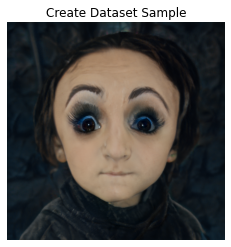

In [17]:
latents = []
latent = torch.load("vectors/tanjirou.pt")["latent"]
latents.append(latent.to(device))
latents = torch.stack(latents, 0)

img = generator(latents, input_is_latent=True)
img = img.squeeze(0)
target_im = utils.make_grid(img, normalize=True, range=(-1, 1))
display_image(target_im, title='Create Dataset Sample')